In [1]:

from datetime import date, time, datetime
from os import listdir, mkdir
from os.path import exists, join
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg

import parse_data
from PlotnineElements import blank, PlotnineElements as pe

pd.set_option('display.max_columns', 500)

In [31]:
# Plot stuff
background =        '#0F0F22'
avg_line_colour =   '#FFFFFF'

dark_green =        '#1B6423'
green =             '#009900'
bright_green =      '#99ff99'
yellow =            '#ffff66'
pale_blue =         '#5eabb4'
blue =              '#3333ff'
pink =              '#F36AE0'
red =               '#ff0000'


dark_blue =         '#10101a'
pale_yellow =       '#ffffcc'
yellow =            '#ffff66'
pale_yellow =       '#ffffcc'
sponsor_blue =      '#79a2d8'
light_blue =        '#ccdbed'
silver =            '#9999cc'

custom_colours = [dark_green, green, bright_green, yellow, pale_blue, blue, pink, red]
custom_colours_4 = [pale_blue, blue, pink, red]
custom_duo = [green, red]
text_colour = '#ffffff'

# Make the Files

In [32]:
# daily = parse_data.make_daily(first_year=2022)

In [33]:
# yearly = parse_data.make_yearly(first_year=2022)

# Plots

Plots to make:
- Plot the completion numbers for this year so far
- Plot the completions for this year vs previous, facet on first and second
- box plot of completion times for this year's dates
- Plot the relative completion times for each year?
- Plot the relative difficulty of the second part, ratio of completions and ratio of times

In [34]:
daily = parse_data.get_daily()
yearly = parse_data.get_yearly()
cur_year = date.today().year
cur_day = date.today().day - 1

## Drop the current day stats as they are likely incomplete

In [35]:
# daily = daily.drop(daily.query('(year == @cur_year) & (day == @cur_day + 1)').index)

In [36]:
yearly = yearly.drop(yearly.query('(year == @cur_year) & (day == @cur_day + 1)').index)

# Data Prep

## Yearly

In [37]:
# Compute the ratio of completion of question 2 to question 1 in a separate dataframe
yearly_ratio = yearly.copy(deep=True)
yearly_ratio = yearly_ratio.set_index(['year', 'day', 'completion'])['count'].unstack().reset_index()

yearly_ratio['ratio'] = yearly_ratio.apply(lambda x: x[2]/x[3], axis=1)

# Compute 
yearly_average_average = yearly_ratio.query('year < @cur_year').groupby(by=['day']).agg('mean').reset_index()
yearly_average_average['year'] = 'Mean'


# Compute the difference in players from one day to next
yearly = yearly.sort_values(by=['year', 'day', 'completion'])
yearly['day_dropoff'] = yearly.groupby(by=['year', 'completion'])['count'].diff(periods=1) * -1

def day_dropoff_ratio(ipt):
        # year day Completed Count day_diff
        vals = yearly.loc[(yearly['year'] == ipt[0]) & (yearly['day'] == (ipt[1] - 1)) & (yearly['completion'] == ipt[2]), 'count'].values
        # vals = vals[0] if len(vals) > 0 else 
        return (ipt['count'] / vals[0] if len(vals) > 0 else None)

yearly['day_dropoff_ratio'] = yearly.apply(day_dropoff_ratio, axis=1)

def first_day_dropoff(ipt):
        
        return - ipt['count'] + yearly.loc[(yearly['year'] == ipt[0]) & (yearly['day'] == 1) & (yearly['completion'] == ipt[2]), 'count'].values[0]

yearly['first_day_dropoff'] = yearly.apply(first_day_dropoff, axis=1)

# Compute the ratio to the first day of the year
def first_day_dropoff_ratio(ipt):
        # year day Completed Count day_diff
        return ipt['count'] / yearly.loc[(yearly['year'] == ipt[0]) & (yearly['day'] == 1) & (yearly['completion'] == ipt[2]), 'count'].values[0]

yearly['first_day_dropoff_ratio'] = yearly.apply(first_day_dropoff_ratio, axis=1)


## Daily

In [38]:

# Create copy of daily and conert time to seconds
daily_average = daily.copy(deep=True)
daily_average['time'] = daily_average['time'].apply(lambda x: x.total_seconds())

# print(daily_average)

# Group by year, day, and completion and calculate the average time per day per year per question
# daily_average = daily_average.groupby(by=['year', 'day', 'completion']).mean().drop(['position'], axis=1).reset_index()
daily_average = daily_average.groupby(by=['year', 'day', 'completion']).agg(TimeMean=('time', np.mean), TimeMin=('time', np.min), TimeMax=('time', np.max)).reset_index()
print(daily_average)

# Creating the average of all of the daily averages for each calendar day
daily_average_average = daily_average.query('year < @cur_year').groupby(by=['day', 'completion']).mean().reset_index()
daily_average_average['year'] = 'Mean'

     year  day completion  TimeMean  TimeMin  TimeMax
0    2015    1      first   5483.40    338.0   9271.0
1    2015    1     second   6900.15    655.0  11176.0
2    2015    2      first   1133.30    205.0   1919.0
3    2015    2     second   1624.56    327.0   2624.0
4    2015    3      first    651.17    160.0   1070.0
..    ...  ...        ...       ...      ...      ...
377  2022   14     second    695.53    356.0    834.0
378  2022   15      first    515.87    186.0    640.0
379  2022   15     second   1343.41    728.0   1634.0
380  2022   16      first   1104.43    509.0   1433.0
381  2022   16     second   2879.14   1300.0   3857.0

[382 rows x 6 columns]


## Join

In [39]:
yearly_total = yearly.merge(daily_average, how='outer')
yearly_total

,year,day,completion,count,day_dropoff,day_dropoff_ratio,first_day_dropoff,first_day_dropoff_ratio,TimeMean,TimeMin,TimeMax
0,2015,1,first,86625.0,NaN,NaN,0.0,1.000000,5483.40,338.0,9271.0
1,2015,1,second,71008.0,NaN,NaN,0.0,1.000000,6900.15,655.0,11176.0
2,2015,2,first,55488.0,31137.0,0.640554,31137.0,0.640554,1133.30,205.0,1919.0
3,2015,2,second,50079.0,20929.0,0.705259,20929.0,0.705259,1624.56,327.0,2624.0
4,2015,3,first,45290.0,10198.0,0.816213,41335.0,0.522828,651.17,160.0,1070.0
...,...,...,...,...,...,...,...,...,...,...,...
377,2022,14,second,34521.0,3173.0,0.915822,194735.0,0.150578,695.53,356.0,834.0
378,2022,15,first,29825.0,5565.0,0.842752,209175.0,0.124791,515.87,186.0,640.0
379,2022,15,second,24378.0,10143.0,0.706179,204878.0,0.106335,1343.41,728.0,1634.0
380,2022,16,first,NaN,NaN,NaN,NaN,NaN,1104.43,509.0,1433.0


In [40]:
yearly_ratio['question_time'] = (yearly_total.loc[yearly_total['completion'] == 'second', 'TimeMean'].reset_index(drop=True) / yearly_total.loc[yearly_total['completion'] == 'first', 'TimeMean'].reset_index(drop=True))
yearly_ratio

completion,year,day,first,second,ratio,question_time
0,2015,1,86625,71008,1.219933,1.258371
1,2015,2,55488,50079,1.108009,1.433477
2,2015,3,45290,41676,1.086717,1.594422
3,2015,4,37628,36247,1.038100,1.217803
4,2015,5,36693,31170,1.177190,1.990188
...,...,...,...,...,...,...
185,2022,11,61475,54083,1.136679,1.373975
186,2022,12,45441,44635,1.018058,1.267962
187,2022,13,38686,37694,1.026317,1.611798
188,2022,14,35390,34521,1.025173,1.308445


In [41]:
# So now I want a table that is summary statistics, a value per day, considering all years
# and I also want something that is a value per year, for all days

## Summary

In [42]:
# Take the total time and count for 
per_year = (yearly_total.groupby(by=['completion', 'year'])['count', 'day_dropoff', 'day_dropoff_ratio', 'first_day_dropoff', 'first_day_dropoff_ratio', 'TimeMean', 'TimeMin', 'TimeMax']
                        .agg(CountMean=('count', np.mean), 
                             DayDropoffMean=('day_dropoff', np.mean), 
                             DayDropoffRatioMean=('day_dropoff_ratio', np.mean),
                             FirstDayDropoffMean=('first_day_dropoff', np.mean), 
                             FirstDayDropoffRatioMean=('first_day_dropoff_ratio', np.mean), 
                             TimeMean=('TimeMean', np.mean),
                             TimeMin=('TimeMin', np.mean),
                             TimeMax=('TimeMax', np.mean)).reset_index())
per_year
# gg.ggplot(per_day, gg.aes(x='day', y='TimeMean', linetype='completion')) + gg.geom_line()

/var/folders/zz/z3rhbf4x4hdb8gwyxnpw92_40000gn/T/ipykernel_31539/3792512588.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,completion,year,CountMean,DayDropoffMean,DayDropoffRatioMean,FirstDayDropoffMean,FirstDayDropoffRatioMean,TimeMean,TimeMin,TimeMax
0,first,2015,20795.640000,3295.291667,0.913396,65829.360000,0.240065,1261.354000,280.7200,2048.720
1,first,2016,9990.440000,1019.916667,0.930621,18452.560000,0.351244,834.824400,259.0800,1284.280
2,first,2017,18900.560000,2245.000000,0.919063,42282.440000,0.308918,439.648000,159.7200,585.440
3,first,2018,20289.760000,3730.708333,0.907705,74537.240000,0.213966,1060.389600,440.4000,1422.440
4,first,2019,26462.120000,4891.333333,0.894355,95806.880000,0.216425,610.840800,258.5200,827.160
5,first,2020,61085.120000,7177.666667,0.910346,129389.880000,0.320699,323.100000,138.5600,405.720
6,first,2021,70321.320000,9553.916667,0.909854,176352.680000,0.285078,580.446400,243.6400,749.160
7,first,2022,105314.733333,14941.071429,0.865071,133685.266667,0.440647,366.504375,169.6875,454.000
8,second,2015,18984.720000,2733.458333,0.906350,52023.280000,0.267360,1821.946000,411.2400,3076.240
9,second,2016,9139.080000,775.375000,0.937459,12909.920000,0.414490,1455.166800,457.8400,2266.360


In [43]:
per_day =  (yearly_total.groupby(by=['completion', 'day'])['count', 'day_dropoff', 'day_dropoff_ratio', 'first_day_dropoff', 'first_day_dropoff_ratio', 'TimeMean', 'TimeMin', 'TimeMax']
                        .agg(CountMean=('count', np.mean), 
                             DayDropoffMean=('day_dropoff', np.mean), 
                             DayDropoffRatioMean=('day_dropoff_ratio', np.mean),
                             FirstDayDropoffMean=('first_day_dropoff', np.mean), 
                             FirstDayDropoffRatioMean=('first_day_dropoff_ratio', np.mean), 
                             TimeMean=('TimeMean', np.mean),
                             TimeMin=('TimeMin', np.mean),
                             TimeMax=('TimeMax', np.mean)).reset_index())
per_day

/var/folders/zz/z3rhbf4x4hdb8gwyxnpw92_40000gn/T/ipykernel_31539/4170055216.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,completion,day,CountMean,DayDropoffMean,DayDropoffRatioMean,FirstDayDropoffMean,FirstDayDropoffRatioMean,TimeMean,TimeMin,TimeMax
0,first,1,133687.000000,NaN,NaN,0.000000,1.000000,874.138750,96.625000,1426.750000
1,first,2,104969.500000,28717.500000,0.766266,28717.500000,0.766266,316.218750,99.750000,464.500000
2,first,3,85668.625000,19300.875000,0.800049,48018.375000,0.614783,301.605000,93.000000,429.500000
3,first,4,70422.375000,15246.250000,0.841491,63264.625000,0.514215,384.915000,149.875000,514.375000
4,first,5,60726.250000,9696.125000,0.883443,72960.750000,0.451233,351.745000,138.375000,466.750000
5,first,6,56738.875000,3987.375000,0.906117,76948.125000,0.412788,362.051250,134.125000,490.250000
6,first,7,46809.125000,9929.750000,0.842008,86877.875000,0.345039,636.597500,236.875000,893.750000
7,first,8,44158.125000,2651.000000,0.927205,89528.875000,0.319142,353.560000,128.875000,480.375000
8,first,9,38367.875000,5790.250000,0.868004,95319.125000,0.278755,521.826250,203.250000,721.875000
9,first,10,35946.625000,2421.250000,0.938222,97740.375000,0.257667,535.778750,189.625000,739.250000


# Plots

# Completions over Days Plots
- These mostly show retention over time

## Total Completions per day
- The solid and dashed white lines show the expected dropoff this year if the average of the previous years was applied
  - If purple is above this line then there is better than average retention

/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 14 x 8 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/PlayerCountMacro.png
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


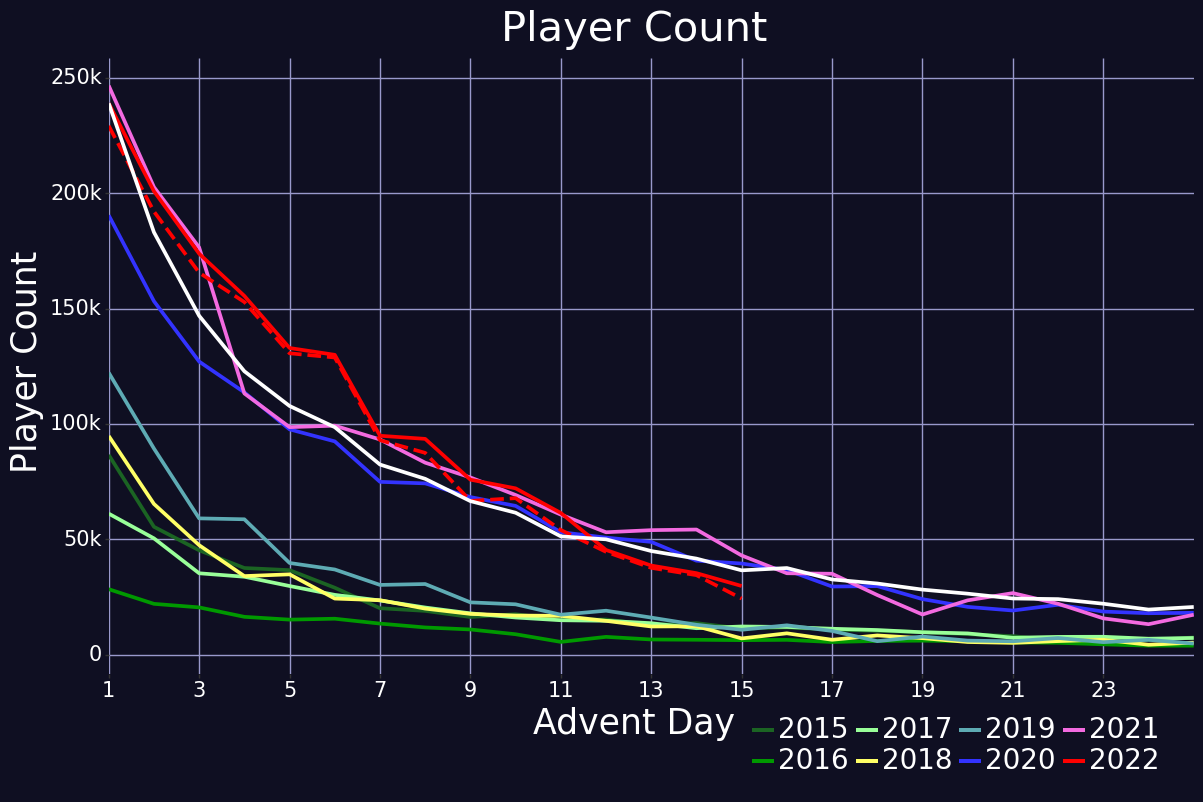

<ggplot: (382320734)>

In [44]:
# These values are used for the expected lines
first_val = yearly_total.query("(year == 2022) & (day == 1) & (completion == 'first')")['count'].values[0]
second_val = yearly_total.query("(year == 2022) & (day == 1) & (completion == 'second')")['count'].values[0]

g = (gg.ggplot(yearly_total.query("(year == @cur_year) or (completion == 'first')"), gg.aes(x='day', y='count/1000', colour='factor(year)', linetype='completion')) 
    + gg.geom_line(size=1.5)

    + gg.geom_line(per_day.query('(completion == "first")'), gg.aes(x='day', y='FirstDayDropoffRatioMean * first_val / 1000', linetype='completion'), colour='white', size=1.5)
    # + gg.geom_line(per_day.query('(completion == "second")'), gg.aes(x='day', y='FirstDayDropoffRatioMean * second_val / 1000', linetype='completion'), colour='white', size=2)

    + gg.scale_colour_manual(values=custom_colours)
    + gg.scale_x_continuous(expand=(0,0), breaks=(lambda x: range(x[0], x[1], 2)))
    + gg.scale_y_continuous(labels=(lambda x: [0] + [(f"{y:.0f}" + 'k') for y in x[1:]]))
    + gg.scale_linetype(guide=False)

    + pe.background_colour(background)
    + pe.text(colour=text_colour)
    + pe.labels(x='Advent Day', y='Player Count', title='Player Count', x_size=25, y_size=25, title_size=30)
    + gg.theme(panel_grid=gg.element_line(colour=silver))
    + gg.theme(figure_size=(14, 8))
    + gg.theme(axis_text=gg.element_text(size=15))
    + pe.remove_grid(minor=True)
    + gg.theme(legend_key=blank,
            legend_title=blank,
            legend_text=gg.element_text(size=20),
            legend_direction='horizontal',
            legend_position=(0.73, 0.02)))

if not exists(join(pathlib.Path(__file__).parent.resolve(), 'yearly_data')):
    mkdir(join(pathlib.Path(__file__).parent.resolve(), 'yearly_data'))
g.save('plots/PlayerCountMacro.png')
g

## Total Completions per day up to current day
- The solid and dashed white lines show the expected dropoff this year if the average of the previous years was applied
  - If purple is above this line then there is better than average retention

/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 14 x 8 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/PlayerCount.png


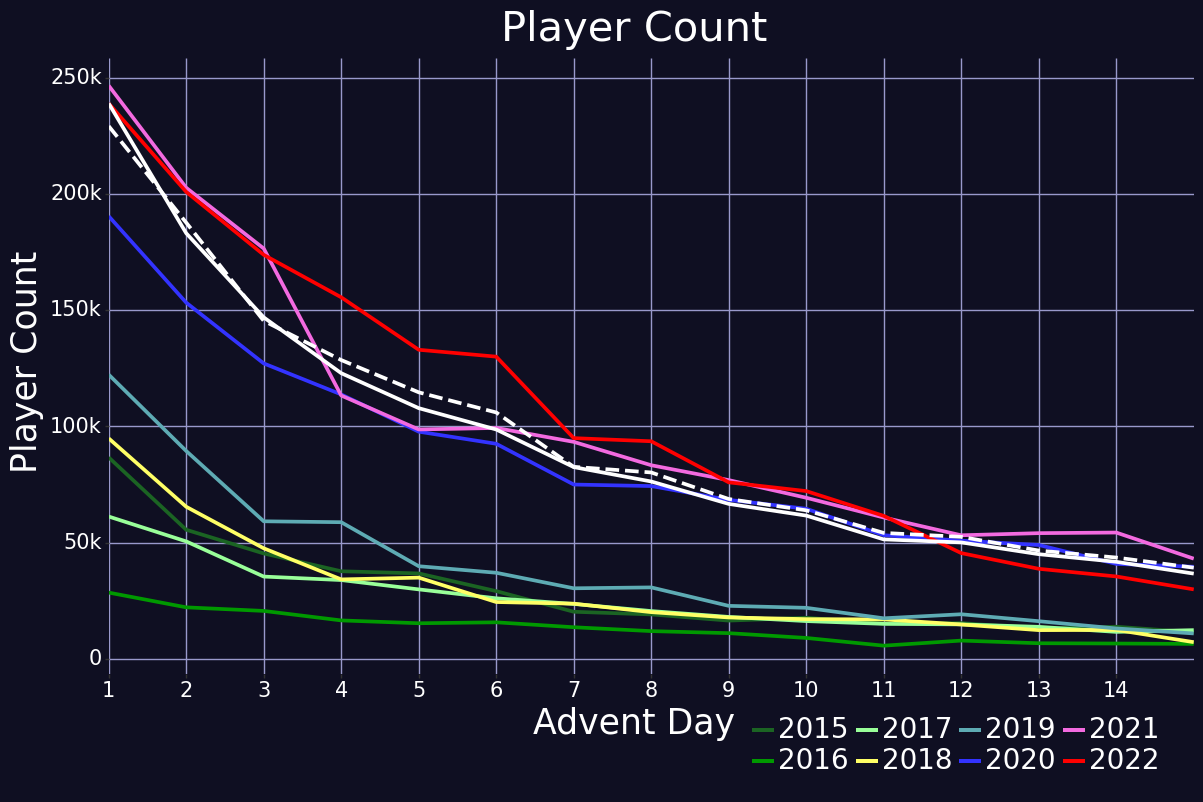

<ggplot: (382396317)>

In [45]:
# These values are used to calculate the running expected, they are multiplied by the expected ratio
first_val = yearly_total.query("(year == 2022) & (day == 1) & (completion == 'first')")['count'].values[0]
second_val = yearly_total.query("(year == 2022) & (day == 1) & (completion == 'second')")['count'].values[0]

g = (gg.ggplot(yearly_total.query('(day <= @cur_day) & (completion == "first")'), gg.aes(x='day', y='count / 1000', colour='factor(year)', linetype='completion')) 
        + gg.geom_line(size=1.5)
        
        + gg.geom_line(per_day.query('(day <= @cur_day) & (completion == "first")'), gg.aes(x='day', y='FirstDayDropoffRatioMean * first_val / 1000', linetype='completion'), colour='white', size=1.5)
        + gg.geom_line(per_day.query('(day <= @cur_day) & (completion == "second")'), gg.aes(x='day', y='FirstDayDropoffRatioMean * second_val / 1000', linetype='completion'), colour='white', size=1.5)

        + gg.scale_colour_manual(values=custom_colours)
        + gg.theme(figure_size=(14, 8))
        + gg.scale_x_continuous(expand=(0,0), breaks=(lambda x: range(x[0], x[1])))
        + gg.scale_y_continuous(labels=(lambda x: [0] + [(f"{y:.0f}" + 'k') for y in x[1:]]))
        + gg.scale_linetype(guide=False)

        + pe.background_colour(background)
        + pe.text(colour=text_colour)
        + pe.labels(x='Advent Day', y='Player Count', title='Player Count', x_size=25, y_size=25, title_size=30)
        + gg.theme(panel_grid=gg.element_line(colour=silver))
        + gg.theme(figure_size=(14, 8))
        + gg.theme(axis_text=gg.element_text(size=15))
        + pe.remove_grid(minor=True)
        + gg.theme(legend_key=blank,
                legend_title=blank,
                legend_text=gg.element_text(size=20),
                legend_direction='horizontal',
                legend_position=(0.73, 0.02)))
g.save('plots/PlayerCount.png')
g

## Ratio of Completions per day to first day completions
- White line shows expected retention
- Dashed line shows first-only completion

/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 14 x 8 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/NormalizedPlayerRetentionMacro.png
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


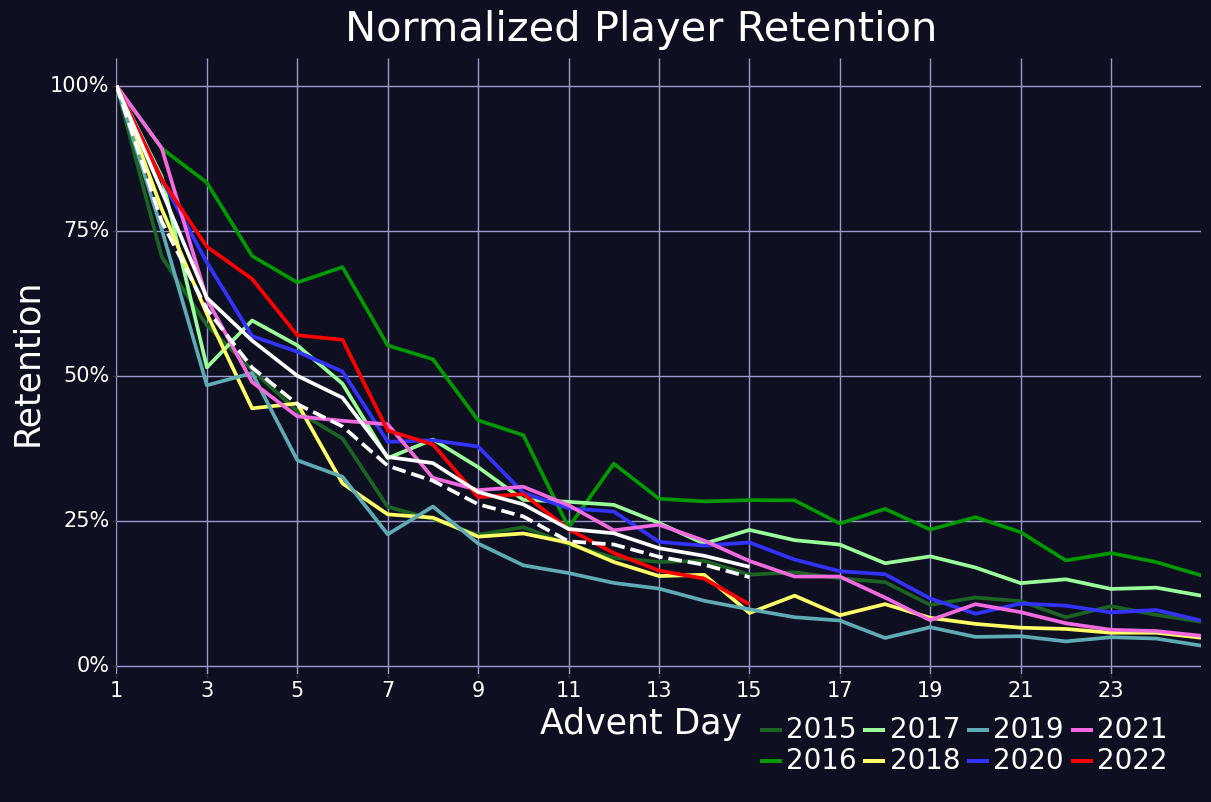

<ggplot: (384544441)>

In [46]:
# These values are used for the expected lines
first_val = yearly_total.query("(year == 2022) & (day == 1) & (completion == 'first')")['count'].values[0]
second_val = yearly_total.query("(year == 2022) & (day == 1) & (completion == 'second')")['count'].values[0]

g = (gg.ggplot(yearly_total.query('(completion == "second")'), gg.aes(x='day', y='first_day_dropoff_ratio', colour='factor(year)', linetype='completion')) 
        + gg.geom_line(size=1.5)
        
        + gg.geom_line(per_day.query('(day <= @cur_day) & (completion == "first")'), gg.aes(x='day', y='FirstDayDropoffRatioMean', linetype='completion'), colour='white', size=1.5)
        + gg.geom_line(per_day.query('(day <= @cur_day) & (completion == "second")'), gg.aes(x='day', y='FirstDayDropoffRatioMean', linetype='completion'), colour='white', size=1.5)

        + gg.scale_colour_manual(values=custom_colours)
        + gg.scale_x_continuous(expand=(0,0), breaks=(lambda x: range(x[0], x[1], 2)))
        + gg.scale_y_continuous(labels=(lambda x: [(f"{y * 100:.0f}" + '%') for y in x]), limits=(None, 1))
        + gg.scale_linetype(guide=False)

        + pe.background_colour(background)
        + pe.text(colour=text_colour)
        + gg.theme(panel_grid=gg.element_line(colour=silver))
        + gg.theme(figure_size=(14, 8))
        + gg.theme(legend_key=blank,
                   legend_title=blank)
        + pe.labels(x='Advent Day', y='Retention', title='Normalized Player Retention', x_size=25, y_size=25, title_size=30)
        + gg.theme(axis_text=gg.element_text(size=15))
        + pe.remove_grid(minor=True)
        + gg.theme(legend_key=blank,
                legend_title=blank,
                legend_text=gg.element_text(size=20),
                legend_direction='horizontal',
                legend_position=(0.73, 0.02)))
g.save('plots/NormalizedPlayerRetentionMacro.png')
g

## Ratio of Completions to current day

/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 14 x 8 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/NormalizedPlayerRetention.png


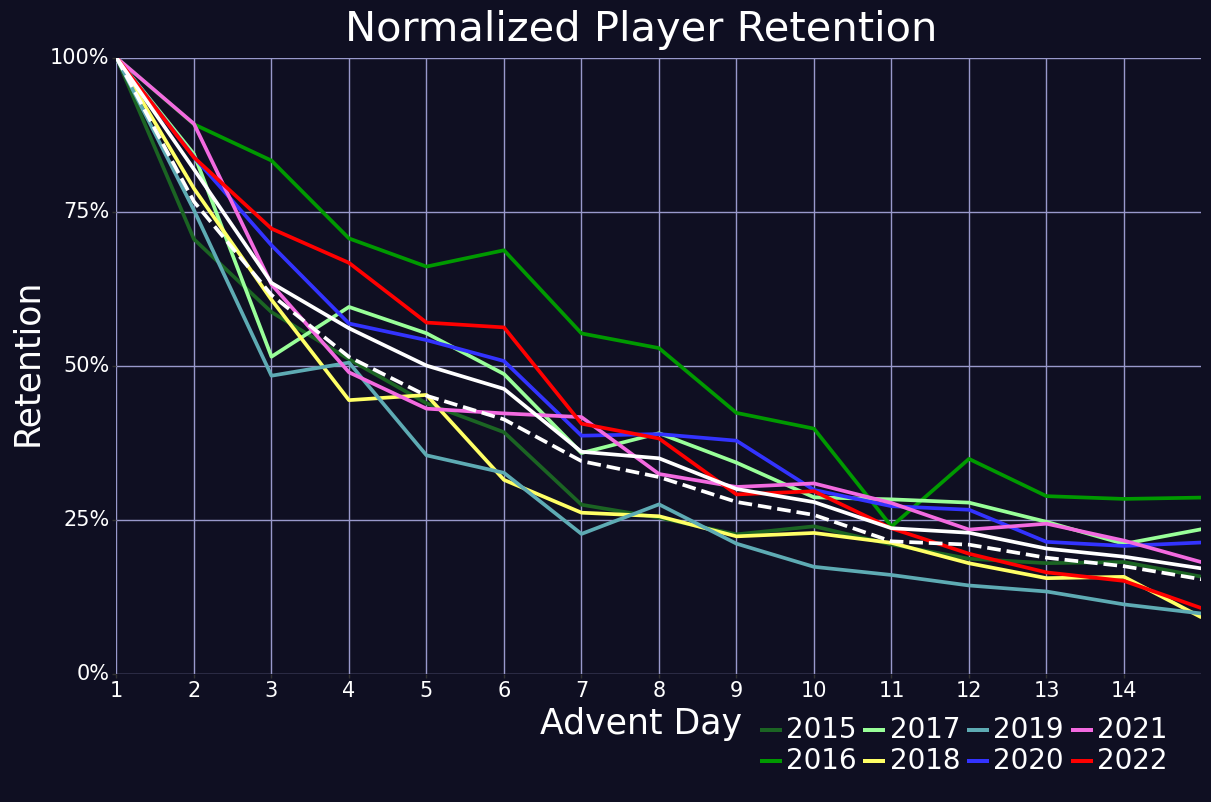

<ggplot: (381788124)>

In [47]:
# These values are used for the expected lines
first_val = yearly_total.query("(year == 2022) & (day == 1) & (completion == 'first')")['count'].values[0]
second_val = yearly_total.query("(year == 2022) & (day == 1) & (completion == 'second')")['count'].values[0]

g = (gg.ggplot(yearly_total.query('(day <= @cur_day) & (completion == "second")'), gg.aes(x='day', y='first_day_dropoff_ratio', colour='factor(year)', linetype='completion')) 
        + gg.geom_line(size=1.5)
        
        + gg.geom_line(per_day.query('(day <= @cur_day) & (completion == "first")'), gg.aes(x='day', y='FirstDayDropoffRatioMean', linetype='completion'), colour='white', size=1.5)
        + gg.geom_line(per_day.query('(day <= @cur_day) & (completion == "second")'), gg.aes(x='day', y='FirstDayDropoffRatioMean', linetype='completion'), colour='white', size=1.5)

        + gg.scale_colour_manual(values=custom_colours)
        + gg.scale_y_continuous(labels=(lambda x: [(f"{y * 100:.0f}" + '%') for y in x]), limits=[0, 1], expand=(0,0))
        + gg.scale_x_continuous(expand=(0,0), breaks=(lambda x: range(x[0], x[1])))
        + gg.scale_linetype(guide=False)

        + pe.text(colour=text_colour)
        + pe.background_colour(background)
        + pe.text(colour=text_colour)
        + gg.theme(panel_grid=gg.element_line(colour=silver))
        + gg.theme(figure_size=(14, 8))
        + pe.labels(x='Advent Day', y='Retention', title='Normalized Player Retention', x_size=25, y_size=25, title_size=30)
        + gg.theme(axis_text=gg.element_text(size=15))
        + pe.remove_grid(minor=True)
        + gg.theme(legend_key=blank,
                legend_title=blank,
                legend_text=gg.element_text(size=20),
                legend_direction='horizontal',
                legend_position=(0.73, 0.02)))
g.save('plots/NormalizedPlayerRetention.png')
g

# Completion Time Plots

## Average Completion times per day, per year
- This shows the average time that it took for people in the top 100 leaderboard
- The theory is that a harder problem will take more time
- It is unfortunate that I can only gather times for the top 100 as this clearly isn't representative of most people
- It is possible that a problem wasn't significantly more difficult but it just required more manual effort

/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 14 x 14 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/CompletionTime19-22.png


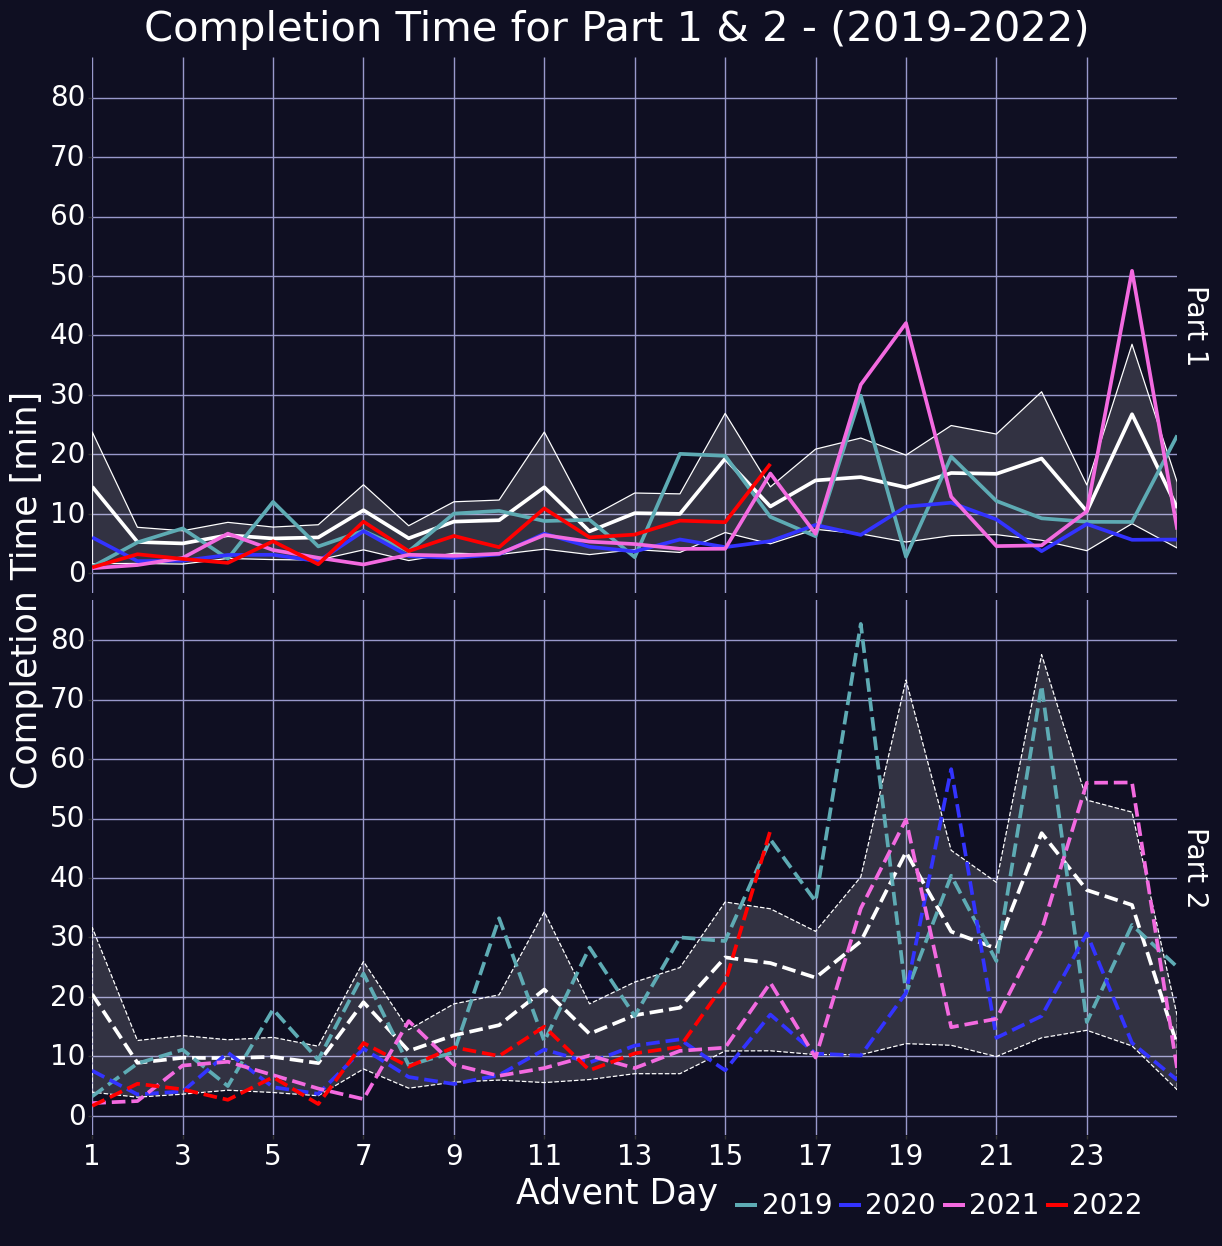

<ggplot: (381684839)>

In [48]:
facet_version = yearly_total.copy(deep=True)
facet_version2 = per_day.copy(deep=True)
facet_version.loc[facet_version['completion'] == 'first', 'completion'] = 'Part 1'
facet_version.loc[facet_version['completion'] == 'second', 'completion'] = 'Part 2'
facet_version2.loc[facet_version2['completion'] == 'first', 'completion'] = 'Part 1'
facet_version2.loc[facet_version2['completion'] == 'second', 'completion'] = 'Part 2'
g = (gg.ggplot(facet_version.query('year > 2018'), gg.aes(x='day', y='TimeMean', colour='factor(year)', linetype='completion')) 
        # + gg.geom_line(size=1.5)
        + gg.geom_ribbon(facet_version2, gg.aes(x='day', ymin="TimeMin", ymax="TimeMax"), colour=avg_line_colour, fill=avg_line_colour, size=0.5, alpha=0.15)
        + gg.geom_line(facet_version2, gg.aes(x='day', y='TimeMean'), colour=avg_line_colour, size=1.5)
        + gg.geom_line(size=1.5)

        + gg.scale_colour_manual(values=custom_colours_4)
        + gg.scale_x_continuous(expand=(0,0), breaks=(lambda x: range(x[0], x[1], 2)))
        + gg.scale_y_continuous(breaks=(lambda x: range(0, int(x[1]), 600)), labels=(lambda x: [f"{i * 10}" for i, v in enumerate(x)]))
        + gg.scale_linetype(guide=False)

        + gg.facet_grid('completion ~ .')
        + pe.text(colour=text_colour)
        + gg.theme(strip_background=blank, strip_text=gg.element_text(size=20))
        + pe.background_colour(background)
        + pe.text(colour=text_colour)
        + gg.theme(panel_grid=gg.element_line(colour=silver))
        + gg.theme(figure_size=(14, 14))
        + pe.labels(x='Advent Day', y='Completion Time [min]', title='Completion Time for Part 1 & 2 - (2019-2022)', x_size=25, y_size=25, title_size=30)
        + gg.theme(axis_text=gg.element_text(size=20))
        + pe.remove_grid(minor=True)
        + gg.theme(legend_key=blank,
                legend_title=blank,
                legend_text=gg.element_text(size=20),
                legend_direction='horizontal',
                legend_position=(0.73, 0.06)))
g.save('plots/CompletionTime19-22.png')
g

## Average ratio of second completion to first completion
Should indicate the difficulty of the second question compared to the first  
The total number of completions shouldn't be an accurate display of this because there is a natural dropoff of people  
I could potentially try to 'normalize' for the average dropoff rate and see if there is a larger drop

/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 14 x 8 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/CompletionRatio.png


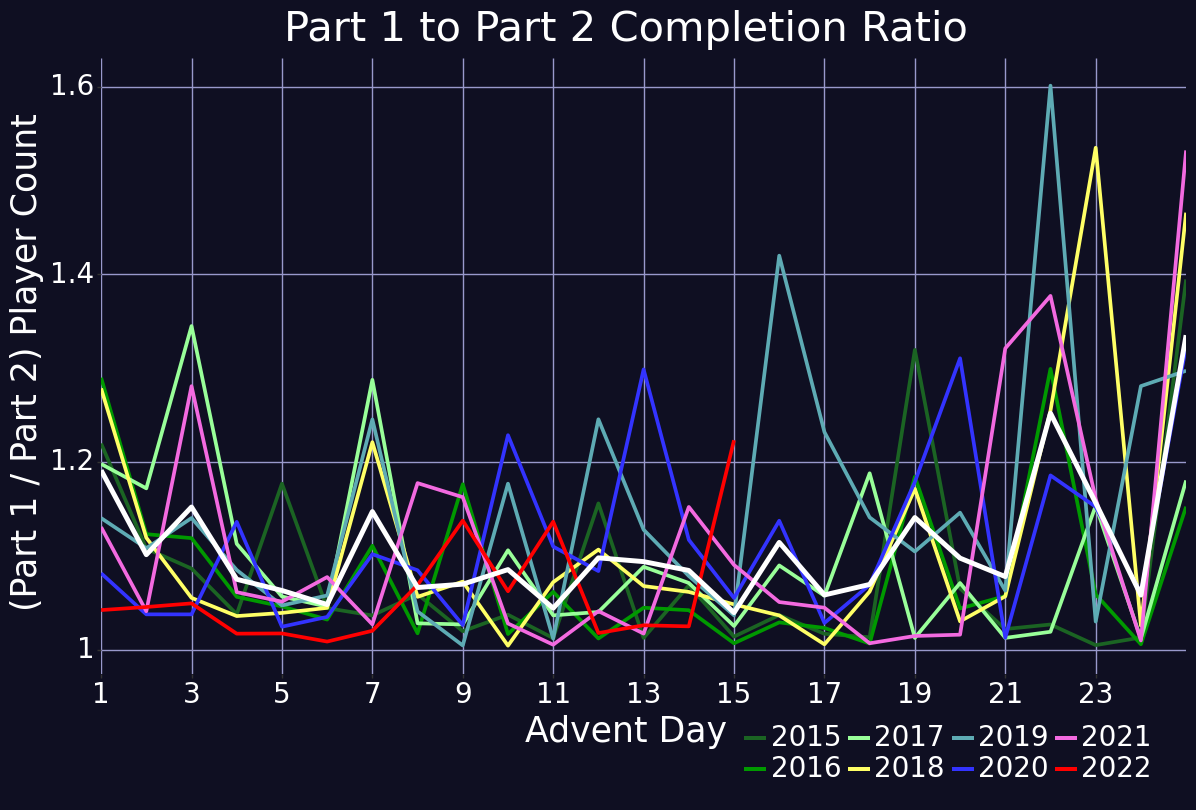

<ggplot: (381787194)>

In [49]:
g = (gg.ggplot(yearly_ratio, gg.aes(x='day', y='ratio', colour='factor(year)')) 
        + gg.geom_line(size=1.5)
        + gg.geom_line(yearly_average_average, colour=avg_line_colour, size=2)

        + gg.scale_colour_manual(values=custom_colours)
        + gg.scale_x_continuous(expand=(0,0), breaks=(lambda x: range(x[0], x[1], 2)))

        + gg.theme(panel_grid=gg.element_line(colour=silver))
        + pe.text(colour=text_colour)
        + gg.theme(strip_background=blank, strip_text=gg.element_text(size=20))
        + pe.background_colour(background)
        + pe.text(colour=text_colour)
        + gg.theme(panel_grid=gg.element_line(colour=silver))
        + gg.theme(figure_size=(14, 8))
        + pe.labels(x='Advent Day', y='(Part 1 / Part 2) Player Count', title='Part 1 to Part 2 Completion Ratio', x_size=25, y_size=25, title_size=30)
        + gg.theme(axis_text=gg.element_text(size=20))
        + pe.remove_grid(minor=True)
        + gg.theme(legend_key=blank,
                legend_title=blank,
                legend_text=gg.element_text(size=20),
                legend_direction='horizontal',
                legend_position=(0.73, 0.01)))
g.save('plots/CompletionRatio.png')
g

## Plot the ribbon and line for the min, max, and average times to complete

/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 14 x 30 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/CompletionTimeMacro.png


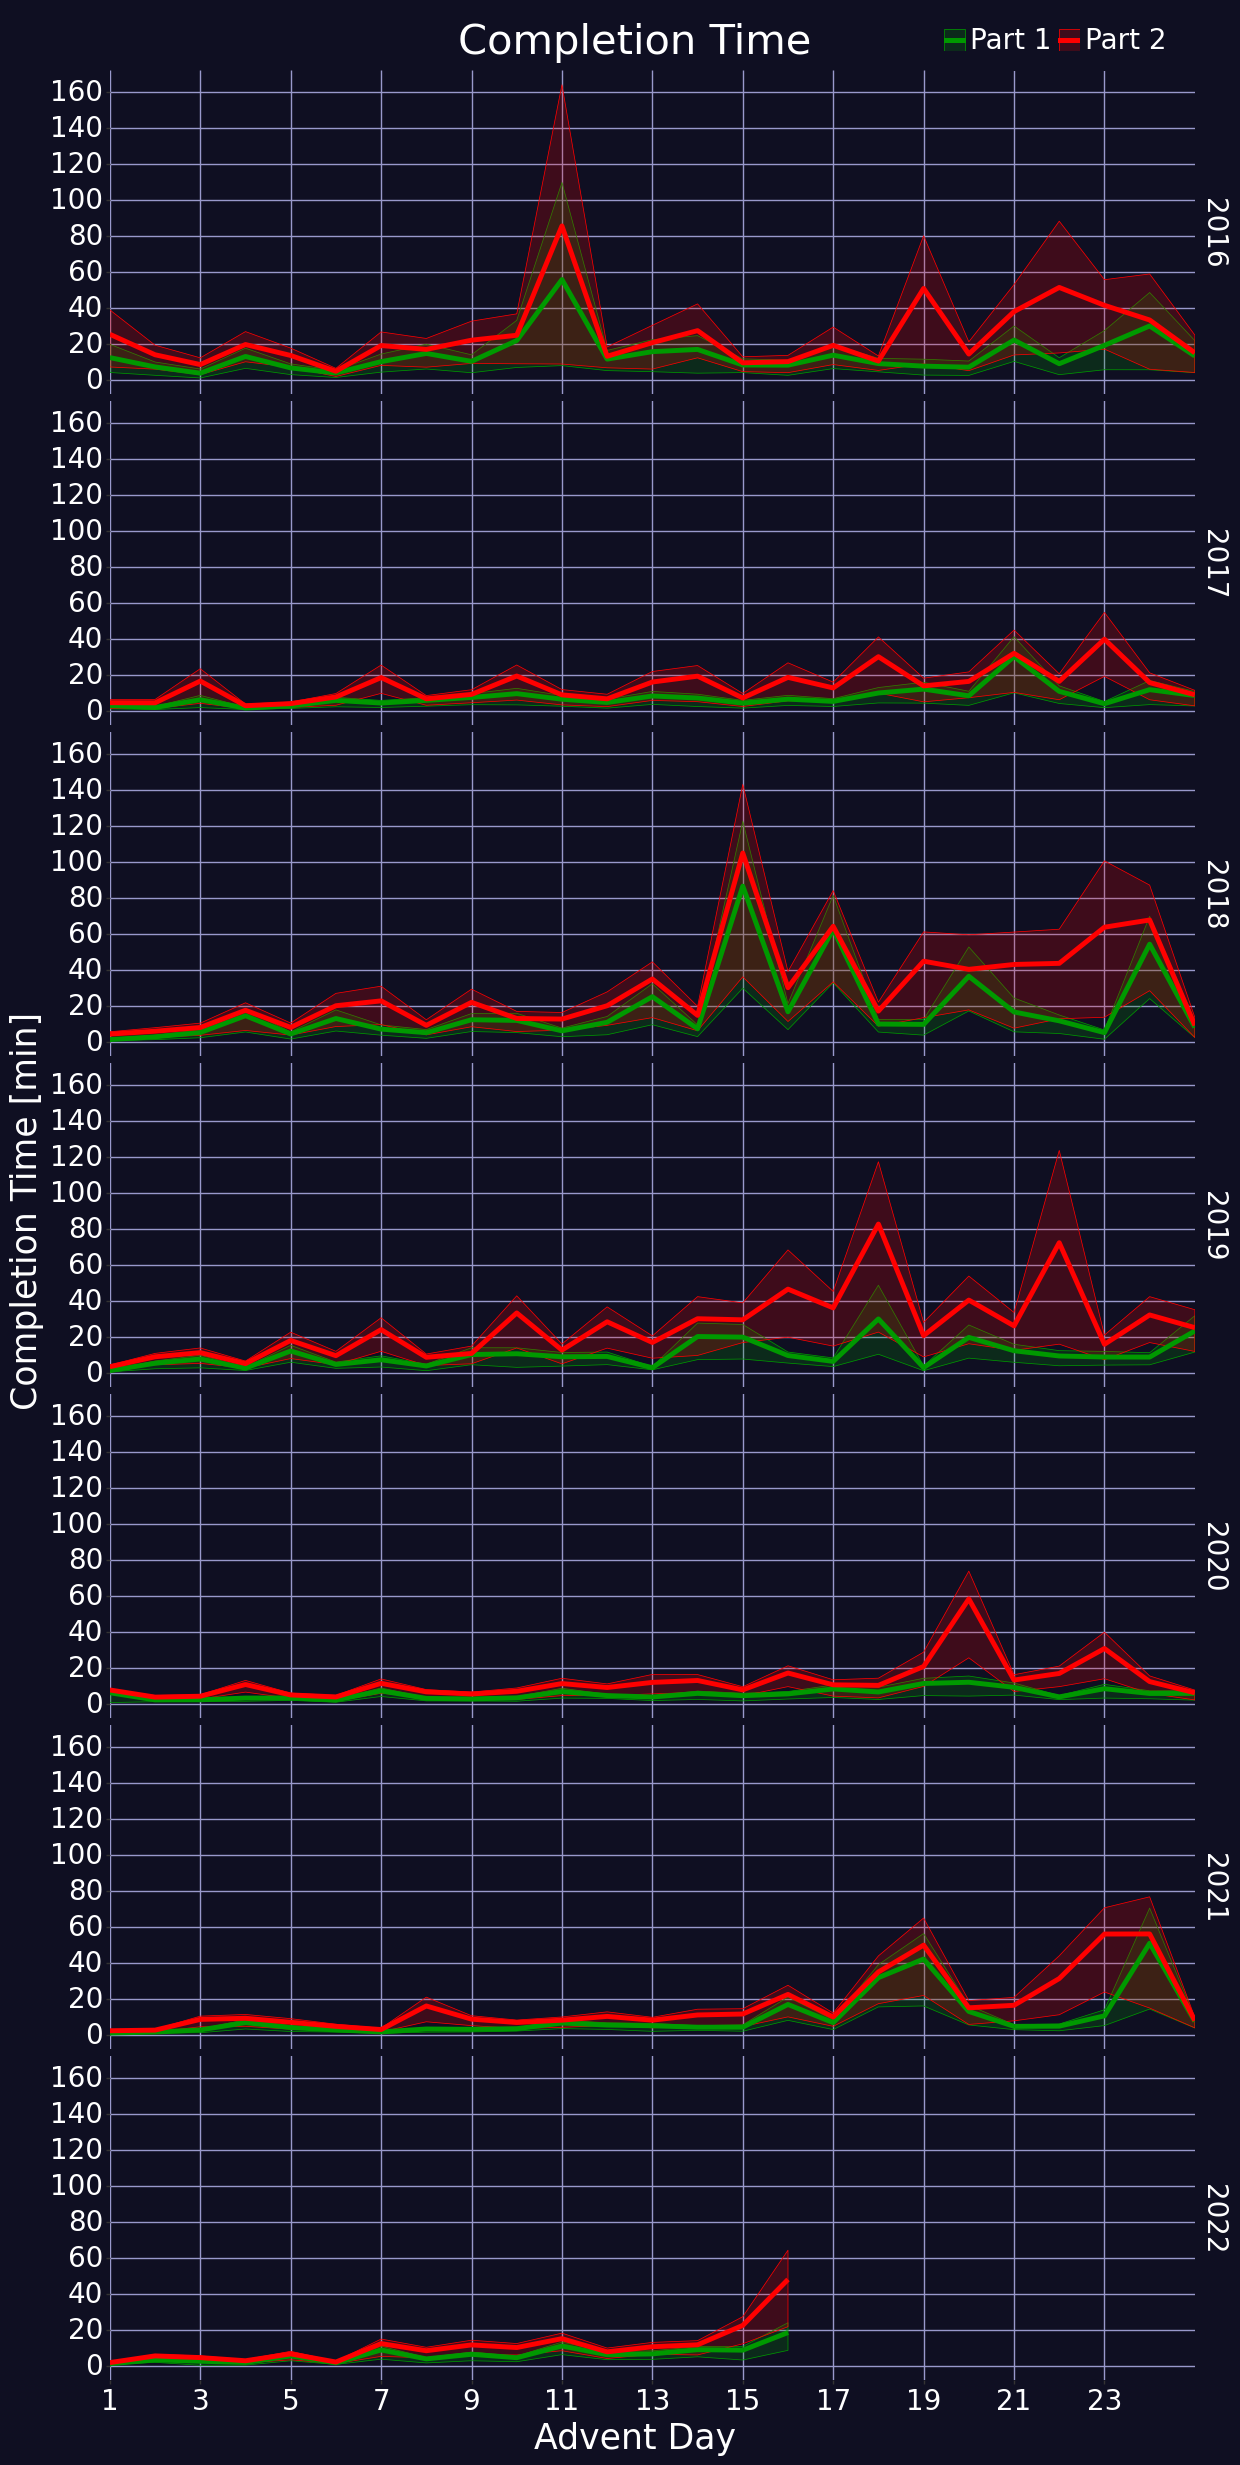

<ggplot: (382295152)>

In [50]:
g = (gg.ggplot(facet_version.query('(year >= 2016)'), gg.aes(x='day', y='TimeMean', colour='completion')) 

    + gg.geom_ribbon(gg.aes(ymin='TimeMin', ymax='TimeMax', fill='completion'), alpha=0.2, size=0.3)
    + gg.geom_line(size=2)
    + gg.facet_grid('year ~ .')

    + gg.scale_colour_manual(values=custom_duo)
    + gg.scale_fill_manual(values=custom_duo)
    + gg.scale_x_continuous(expand=(0,0), breaks=(lambda x: range(x[0], x[1], 2)))
    + gg.scale_y_continuous(breaks=(lambda x: range(0, int(x[1]), 1200)), labels=(lambda x: [f"{i * 20}" for i, v in enumerate(x)]))

    + pe.background_colour(background)
    + pe.text(colour=text_colour)
    + gg.theme(panel_grid=gg.element_line(colour=silver))
    + pe.remove_grid(minor=True)
    + gg.theme(figure_size=(14, 30))
    + gg.theme(strip_background=blank, strip_text=gg.element_text(size=20))
    + gg.theme(legend_key=blank,
                legend_title=blank,
                legend_position=(0.8, 0.89))
    + pe.labels(x='Advent Day', y='Completion Time [min]', title='Completion Time', x_size=25, y_size=25, title_size=30)
    + gg.theme(axis_text=gg.element_text(size=20))
    + pe.remove_grid(minor=True)
    + gg.theme(legend_key=blank,
            legend_title=blank,
            legend_text=gg.element_text(size=20)))
g.save('plots/CompletionTimeMacro.png', limitsize=False)
g

# Current Year Plots

# Plot the current year stuff like time to complete and dropoff

In [51]:
yearly_total.query('year == @cur_year')

,year,day,completion,count,day_dropoff,day_dropoff_ratio,first_day_dropoff,first_day_dropoff_ratio,TimeMean,TimeMin,TimeMax
350,2022,1,first,239000.0,NaN,NaN,0.0,1.000000,60.04,29.0,76.0
351,2022,1,second,229256.0,NaN,NaN,0.0,1.000000,100.20,53.0,125.0
352,2022,2,first,200928.0,38072.0,0.840703,38072.0,0.840703,192.31,109.0,223.0
353,2022,2,second,192132.0,37124.0,0.838067,37124.0,0.838067,323.57,158.0,376.0
354,2022,3,first,173849.0,27079.0,0.865230,65151.0,0.727402,145.46,10.0,183.0
355,2022,3,second,165626.0,26506.0,0.862043,63630.0,0.722450,266.80,137.0,324.0
356,2022,4,first,155560.0,18289.0,0.894800,83440.0,0.650879,105.46,16.0,132.0
357,2022,4,second,152901.0,12725.0,0.923170,76355.0,0.666944,161.47,86.0,202.0
358,2022,5,first,132976.0,22584.0,0.854821,106024.0,0.556385,323.28,160.0,402.0
359,2022,5,second,130674.0,22227.0,0.854631,98582.0,0.569992,390.01,194.0,478.0


/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 14 x 6 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/CompletionTime2022.png


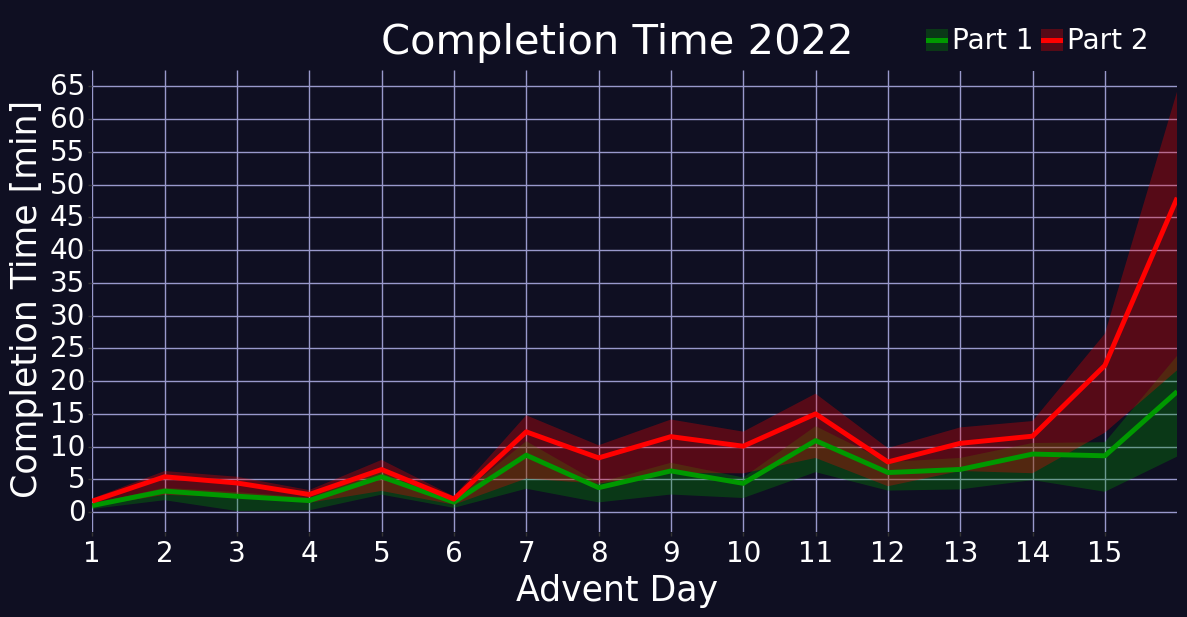

<ggplot: (382256432)>

In [52]:
g = (gg.ggplot(facet_version.query('year == @cur_year'), gg.aes(x='day'))
    + gg.geom_ribbon(gg.aes(ymin='TimeMin', ymax='TimeMax', fill='completion'), size=1, alpha=0.3)
    + gg.geom_line(gg.aes(y='TimeMean', colour='completion'), size=2)

    + gg.scale_colour_manual(values=custom_duo)
    + gg.scale_fill_manual(values=custom_duo)

    + pe.background_colour(background)
    + pe.text(colour=text_colour)
    + gg.theme(panel_grid=gg.element_line(colour=silver))
    + gg.theme(figure_size=(14, 6))
    + gg.scale_x_continuous(expand=(0,0), breaks=(lambda x: range(x[0], x[1])))
    + gg.scale_y_continuous(breaks=(lambda x: range(0, int(x[1]), 300)), labels=(lambda x: [f"{i * 5}" for i, v in enumerate(x)]))

    + pe.background_colour(background)
    + pe.text(colour=text_colour)
    + gg.theme(panel_grid=gg.element_line(colour=silver))
    + pe.remove_grid(minor=True)
    + pe.labels(x='Advent Day', y='Completion Time [min]', title='Completion Time 2022', x_size=25, y_size=25, title_size=30)
    + gg.theme(axis_text=gg.element_text(size=20))
    + pe.remove_grid(minor=True)
    + gg.theme(legend_key=blank,
            legend_title=blank,
            legend_text=gg.element_text(size=20),
            legend_position=(0.8, 0.93)))
g.save('plots/CompletionTime2022.png')
g


In [53]:
daily

,year,day,completion,position,time
0,2020,2,second,1,0 days 00:01:47
1,2020,2,second,2,0 days 00:02:00
2,2020,2,second,3,0 days 00:02:16
3,2020,2,second,4,0 days 00:02:17
4,2020,2,second,5,0 days 00:02:17
...,...,...,...,...,...
38195,2017,20,first,96,0 days 00:10:36
38196,2017,20,first,97,0 days 00:10:39
38197,2017,20,first,98,0 days 00:10:40
38198,2017,20,first,99,0 days 00:10:41


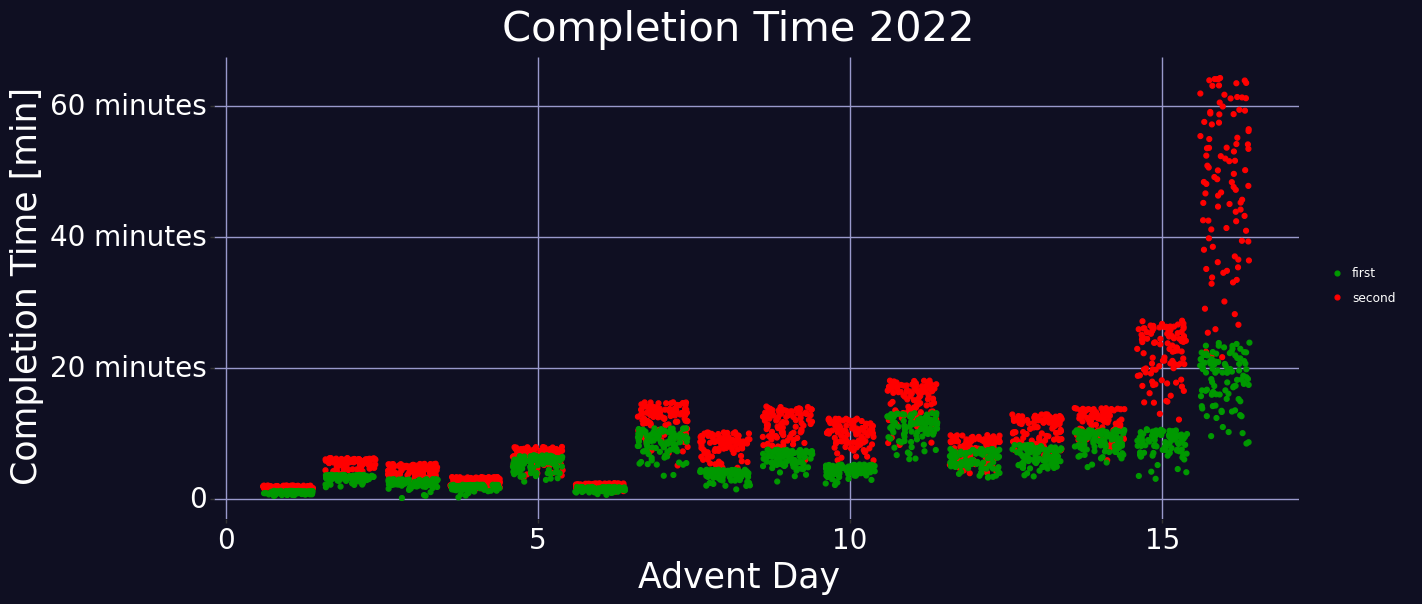

<ggplot: (382411650)>

In [54]:
(gg.ggplot(daily.query('year == 2022'), gg.aes(x='day', y='time', colour='completion')) 
    + gg.geom_jitter()
    + gg.scale_colour_manual(values=custom_duo)
    # + gg.scale_fill_manual(values=custom_duo)

    + pe.text(colour=text_colour)
    + gg.theme(panel_grid=gg.element_line(colour=silver))
    + gg.theme(figure_size=(14, 6))
    # + gg.scale_x_continuous(expand=(0,0), breaks=(lambda x: range(x[0], x[1])))
    # + gg.scale_y_continuous(breaks=(lambda x: range(0, int(x[1]), 120)), labels=(lambda x: [f"{i * 2}" for i, v in enumerate(x)]))

    + pe.background_colour(background)
    + pe.remove_grid(minor=True)
    + pe.labels(x='Advent Day', y='Completion Time [min]', title='Completion Time 2022', x_size=25, y_size=25, title_size=30)
    + gg.theme(axis_text=gg.element_text(size=20))
    + pe.remove_grid(minor=True)
    + gg.theme(legend_key=blank,
            legend_title=blank))

## Plot question completion ratio vs. question time ratio
- This shows that there is at least a small correlation between the ratio of completions and the time ratio, corr() says 0.58
- Though now that I think about this, it may be incorrect
- There are complications here regarding the difficulty of the first compared to the second
  - This really makes a statement on the 2 part relative difficulties, not the absolute difficulty of the day

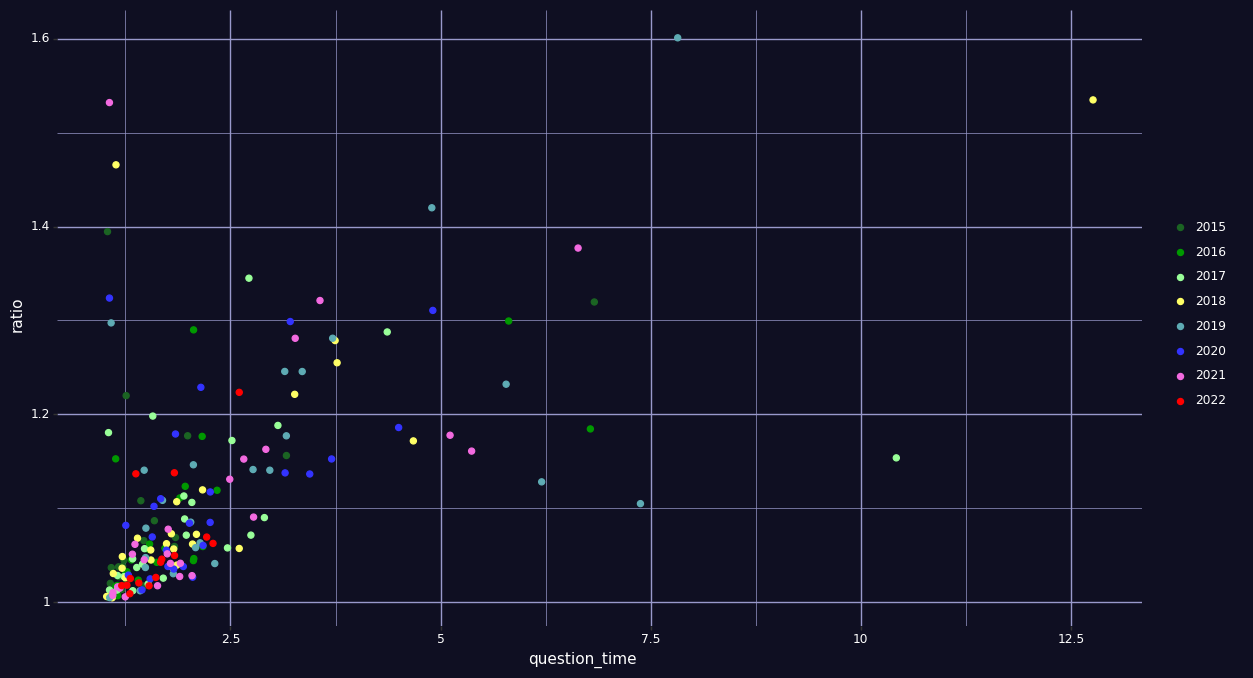

<ggplot: (382438133)>

In [55]:
(gg.ggplot(yearly_ratio, gg.aes(x='question_time', colour='factor(year)')) 
    + gg.geom_point(gg.aes(y='ratio'), size=2)

    + gg.scale_colour_manual(values=custom_colours)
    
    + pe.background_colour(background)
    + pe.text(colour=text_colour)
    + gg.theme(panel_grid=gg.element_line(colour=silver))
    + gg.theme(figure_size=(14, 8))
    + gg.theme(legend_key=blank,
                legend_title=blank))

## Plot the difference in players from day to day

/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 2 rows containing missing values.


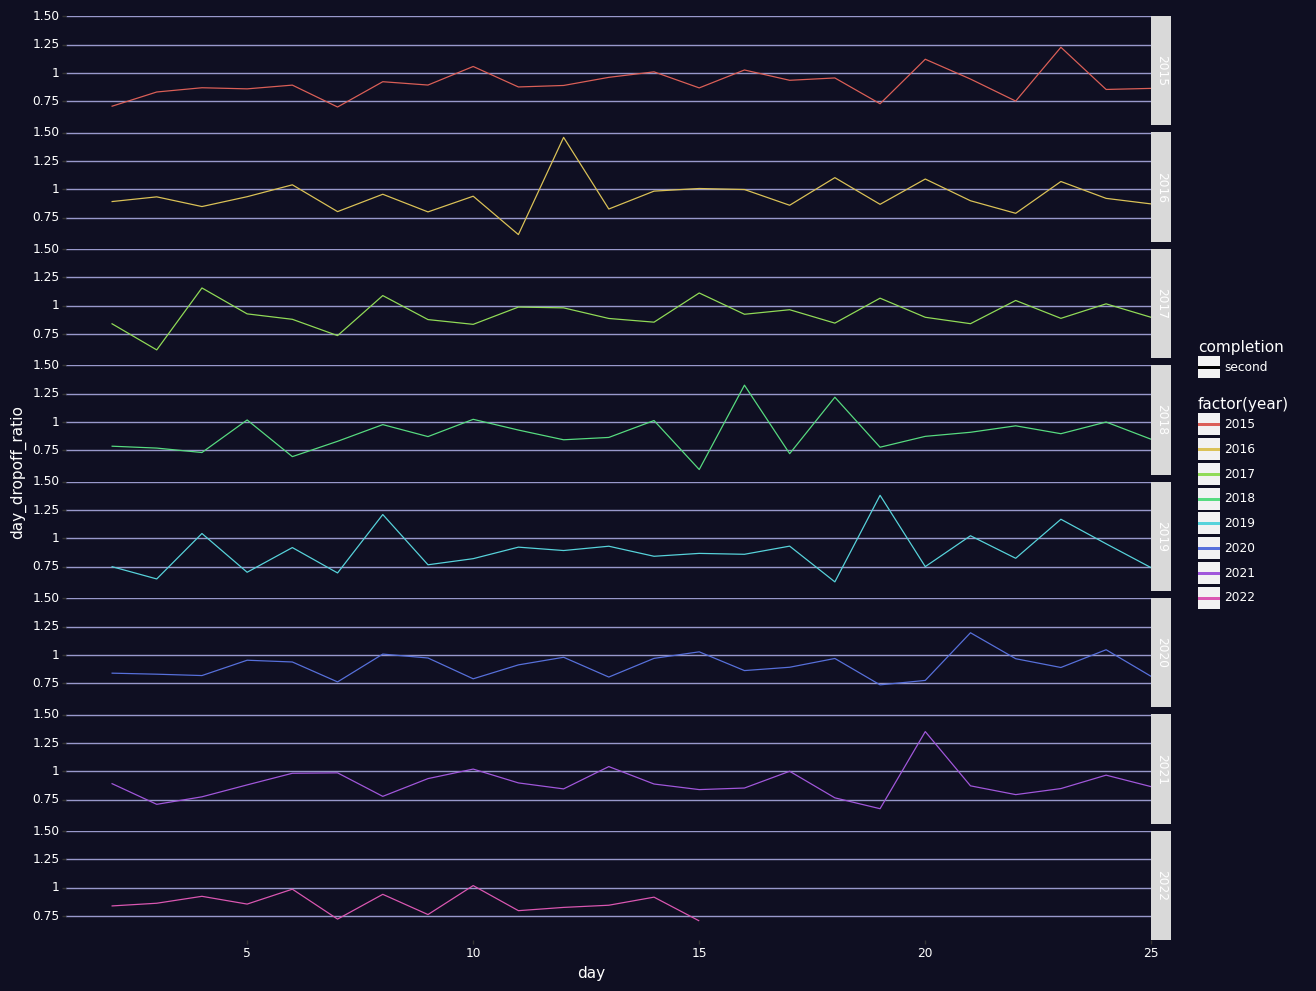

<ggplot: (382507828)>

In [56]:
(gg.ggplot(yearly_total.query('(completion == "second")'), gg.aes(x='day', y='day_dropoff_ratio', colour='factor(year)', linetype='completion')) 
        + gg.geom_line()
        + gg.facet_grid('year ~ .')

        + gg.scale_x_continuous(expand=(0,0))

        + pe.background_colour(background)
        + pe.text(colour=text_colour)
        + gg.theme(panel_grid=gg.element_line(colour=silver))
        + pe.remove_grid(minor=True, x=True)
        + gg.theme(figure_size=(14, 12)))

## Correlation between dropoff ratio and solution time?

In [57]:
yearly_total.corr()

,year,day,count,day_dropoff,day_dropoff_ratio,first_day_dropoff,first_day_dropoff_ratio,TimeMean,TimeMin,TimeMax
year,1.000000,-0.087475,0.548515,0.366347,-0.089611,0.708140,0.052677,-0.233022,-0.052529,-0.276931
day,-0.087475,1.000000,-0.620000,-0.531505,0.261483,0.356785,-0.839609,0.320420,0.387624,0.289951
count,0.548515,-0.620000,1.000000,0.731810,-0.156358,-0.013471,0.713428,-0.326230,-0.356187,-0.302211
day_dropoff,0.366347,-0.531505,0.731810,1.000000,-0.522152,0.017439,0.578275,-0.152962,-0.138685,-0.147975
day_dropoff_ratio,-0.089611,0.261483,-0.156358,-0.522152,1.000000,-0.005113,-0.175374,-0.322666,-0.289319,-0.311084
first_day_dropoff,0.708140,0.356785,-0.013471,0.017439,-0.005113,1.000000,-0.488358,-0.041965,0.099835,-0.081914
first_day_dropoff_ratio,0.052677,-0.839609,0.713428,0.578275,-0.175374,-0.488358,1.000000,-0.276725,-0.392411,-0.238294
TimeMean,-0.233022,0.320420,-0.326230,-0.152962,-0.322666,-0.041965,-0.276725,1.000000,0.833425,0.982137
TimeMin,-0.052529,0.387624,-0.356187,-0.138685,-0.289319,0.099835,-0.392411,0.833425,1.000000,0.741751
TimeMax,-0.276931,0.289951,-0.302211,-0.147975,-0.311084,-0.081914,-0.238294,0.982137,0.741751,1.000000


/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 18 rows containing missing values.


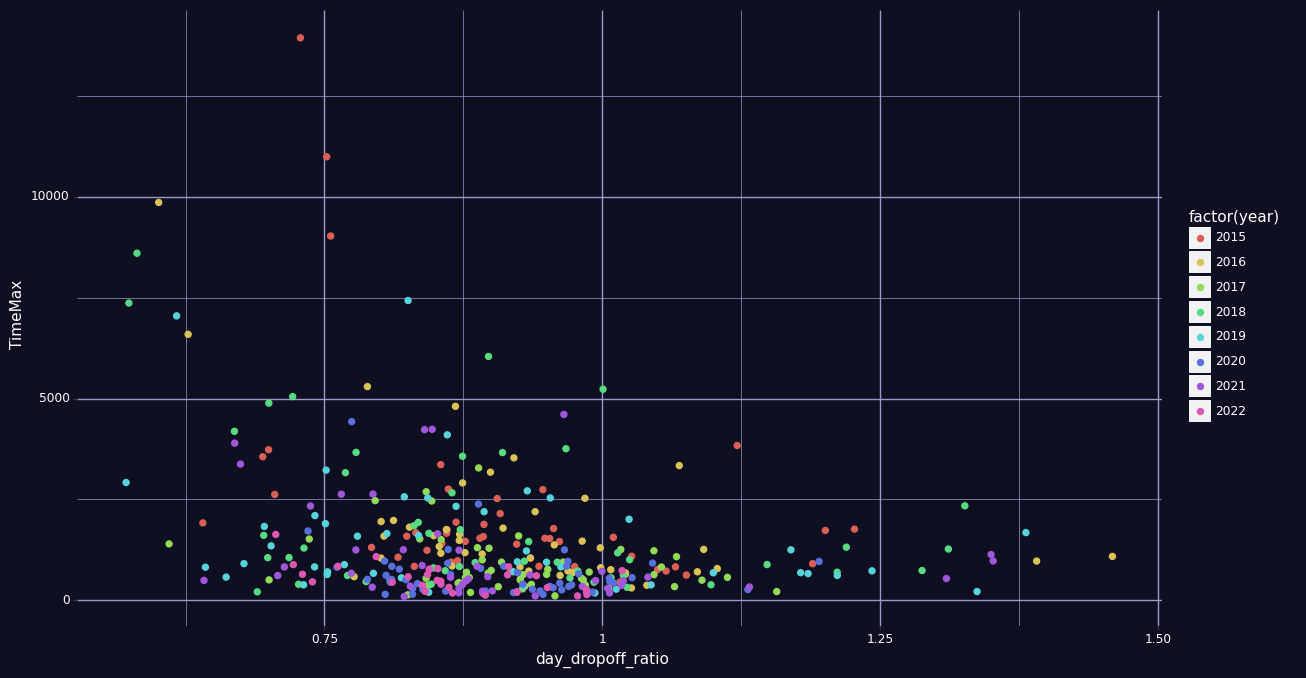

<ggplot: (382468799)>

In [58]:
(gg.ggplot(yearly_total, gg.aes(x='day_dropoff_ratio', colour='factor(year)')) 
    + gg.geom_point(gg.aes(y='TimeMax'), size=2)
    + pe.background_colour(background)
    + pe.text(colour=text_colour)
    + gg.theme(panel_grid=gg.element_line(colour=silver))
    + pe.text(colour='white')
    + gg.theme(figure_size=(14, 8)))